In [ ]:
import sys
from pathlib import Path
import torch

ROOT_PATH=Path("..").resolve().absolute()
DEVICE=torch.device("cuda")#torch.device("cpu")#
sys.path.append(str(ROOT_PATH))

%load_ext autoreload
%autoreload 2

In [ ]:
from misc import load_model
model_piano = load_model(root_path / "data/checkpoints/piano.ckpt", DEVICE)
model_bass = load_model(root_path / "data/checkpoints/bass.ckpt", DEVICE)

/home/giorgio/miniconda3/envs/audio-diffusion-trainer/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7690: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


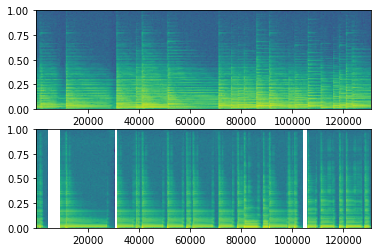

In [ ]:
import torchaudio
from IPython.display import Audio
import math
import matplotlib.pyplot as plt

sampling_rate = 22050

# @markdown Generation length in seconds (will be rounded to be a power of 2 of sample_rate*length)
length = 10
length_samples = 2**math.ceil(math.log2(length * sampling_rate))

# @markdown Number of samples to generate
num_samples = 1

# @markdown Number of diffusion steps (higher tends to be better but takes longer to generate)
num_steps = 10

s1, sr1 = torchaudio.load('/data/5B/Piano_22050/test/Track01881.wav')
s2, sr2 = torchaudio.load('/data/5B/Bass_22050/test/Track01881.wav')

s1 = torchaudio.functional.resample(s1, orig_freq=sr1, new_freq=sampling_rate)
s2 = torchaudio.functional.resample(s2, orig_freq=sr1, new_freq=sampling_rate)

# display(Audio(s1, rate = sampling_rate))
# display(Audio(s2, rate = sampling_rate))

start_sample = 100 * sampling_rate
s1 = s1.reshape(1, 1, -1)[:, :, start_sample:start_sample + length_samples]
s2 = s2.reshape(1, 1, -1)[:, :, start_sample:start_sample + length_samples]
m = s1+s2
#m = m[:, :, start_sample:start_sample + length_samples]


def plot_waves(s1, s2):
    #plt.plot(s1.reshape(-1))
    #plt.plot(s2.reshape(-1))
    
    fig = plt.figure()
    axes = fig.add_subplot(2,1,1)
    spec, _, _, img = plt.specgram(s1.reshape(-1), NFFT=1024,)

    axes = fig.add_subplot(2,1,2)
    spec, _, _, img = plt.specgram(s2.reshape(-1), NFFT=1024,)

    #plt.legend(["piano", "bass"])
    plt.show()
    
    display(Audio(s1.reshape(1,-1), rate = sampling_rate))
    display(Audio(s2.reshape(1,-1), rate = sampling_rate))
    display(Audio((s1+s2).reshape(1,-1), rate = sampling_rate))
    
plot_waves(s1, s2)

In [ ]:
from main.separation import separate

denoise_fns = [model_1.model.diffusion.denoise_fn, model_2.model.diffusion.denoise_fn]
y1, y2 = separate(denoise_fns, m.to(DEVICE), num_steps=200)
#y2 = m - y1.cpu()
#y1 = m - y2.cpu()

SI-SNR (1): 7.9023895263671875
SI-SNR (2): 10.632163047790527
SI-SNRi(1): 9.34669804573059
SI-SNRi (2): 9.981857299804688
SI-SNR (mix): 63.63661193847656


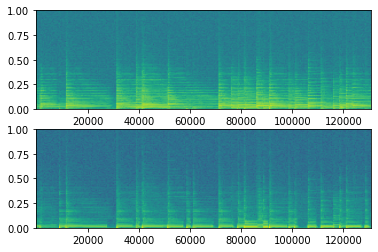

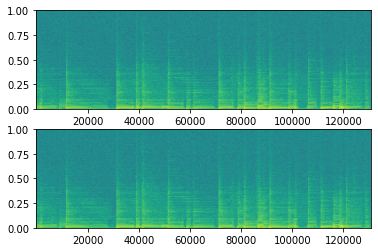

In [ ]:
display(Audio((m).detach().cpu().view(1,-1), rate = sampling_rate))

import torchmetrics.functional.audio as tma
def si_snr(preds, targets):
    return tma.scale_invariant_signal_noise_ratio(preds.cpu(), targets.cpu()).item()

print(f"SI-SNR (1): {si_snr(y1, s1)}")
print(f"SI-SNR (2): {si_snr(y2, s2)}")
print(f"SI-SNRi(1): {si_snr(y1, s1) - si_snr(s1, m)}")
print(f"SI-SNRi (2): {si_snr(y2, s2) - si_snr(s2, m)}")
print(f"SI-SNR (mix): {si_snr(y1+y2, m)}")

plot_waves(y1.cpu(), y2.cpu())
plot_waves((s1.cpu()-y1.cpu()), (s2.cpu()-y2.cpu()))

In [ ]:
from typing import List, Optional

import torch
from torch import Tensor

from audio_diffusion_pytorch.diffusion import AEulerSampler, ADPM2Sampler, Diffusion, KarrasSchedule, Sampler, Schedule
from audio_diffusion_pytorch.model import AudioDiffusionModel
from audio_diffusion_pytorch.utils import default, exists

class DiffusionSeparator:
    def __init__(
        self,
        diffusions: List[Diffusion],
        *,
        samplers: List[Sampler],
        sigma_schedules: List[Schedule],
        num_steps: Optional[int] = None,
        nu = 2e-1
    ):
        super().__init__()
        self.denoise_fns = [diffusion.denoise_fn for diffusion in diffusions]
        self.samplers = samplers
        self.sigma_schedules = sigma_schedules
        self.num_steps = num_steps
        self.nu = nu

    def forward(self, m: Tensor, noises: List[Tensor], num_steps: Optional[int] = None) -> List[Tensor]:
        device = noises[0].device
        num_steps = default(num_steps, self.num_steps)
        assert exists(num_steps), "Parameter `num_steps` must be provided"
        
        # Compute sigmas using schedule
        sigmas_list = [sigma_schedule(num_steps, device) for sigma_schedule in self.sigma_schedules]
        
        # Append additional kwargs to denoise function (used e.g. for conditional unet)
        fns = self.denoise_fns
        
        # Separation procedure
        xs = [sigmas[0] * noise for sigmas, noise in zip(sigmas_list, noises)]
        
        likelihood_steps = torch.tensor([self.nu]*len(sigmas_list[0]))
        #likelihood_steps = compute_likelihood_steps(sigmas_list[0], gamma=2.25)

        @torch.no_grad()
        def perform_sample_step(xs:list, step:int):
            for j, x in enumerate(xs):
                    yield self.samplers[j].step(
                        x, fn=fns[j], sigma=sigmas_list[j][step], sigma_next=sigmas_list[j][step + 1])
                    
        # Denoise to sample
        for step in range(num_steps - 1):
            us = list(perform_sample_step(xs, step))
            g_x = torch.stack(xs).sum(dim=0)
            likelihood = self.nu*(m - g_x)
            
            if step % 20 == 0:
                likelihood_norm = torch.norm(m - g_x)
                print("likelihood norm:", likelihood_norm.item())
                print("step-size:", step_size)
                print("prior 1 norm:", torch.norm(us[0] - xs[0]).item())
                print("prior 2 norm:", torch.norm(us[1] - xs[1]).item())
                print("")
                #plot_waves(xs[0].cpu(), xs[1].cpu())
            
            for i in range(len(xs)):
                xs[i] = us[i] + likelihood
                
        xs = [x.clamp(-1.0, 1.0) for x in xs]
        print(likelihood_norm.item())
        return xs


@torch.no_grad()
def separate(
    model1,
    model2,
    mixture, 
    device: torch.device = torch.device("cuda"), 
    num_steps:int = 402,
):
    
    batch, in_channels = 1, 1
    samples = mixture.shape[-1]

    m = torch.tensor(mixture).to(device)
    models = [model1.model, model2.model]
    
    for model in models:
        model.to(device)
    
    #schedule = lambda num_steps,device: torch.flip(torch.sort(diffusion_sigma_distribution(num_steps*10, device))[0][::10],dims=[0])
    #schedule = lambda num_steps, device: torch.arange(0.6, 0.0, -0.6/num_steps,device=device)
    schedule = KarrasSchedule(sigma_min=1e-4, sigma_max=1.0, rho=9.0)
    
    diffusion_separator = DiffusionSeparator(
        [model.diffusion for model in models],
        samplers=[ADPM2Sampler(), ADPM2Sampler()],
        sigma_schedules=[schedule, schedule],
        num_steps=num_steps
    )

    noises = [torch.randn_like(m).to(device), torch.randn_like(m).to(device)]
    return diffusion_separator.forward(m, noises)


def compute_likelihood_steps(sigmas_rev: torch.tensor, gamma:float=1.0) -> torch.tensor:
    sigmas = sigmas_rev.flip(dims=[0])
    likelihood_steps = 1.0 / (torch.tensor([((2*(sigmas[:step])**2).sum()) for step in range(len(sigmas))]) + gamma**2)
    return likelihood_steps.flip(dims=[0])


y1, y2 = separate(model_1, model_2, m)

<ipython-input-35-0cd48b9367fc>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m = torch.tensor(mixture).to(device)


likelihood norm: 724.1915283203125
step-size: 0.2
prior 1 norm: 86.16978454589844
prior 2 norm: 86.42849731445312

likelihood norm: 113.45216369628906
step-size: 0.2
prior 1 norm: 65.07030487060547
prior 2 norm: 65.0937271118164

likelihood norm: 85.17774963378906
step-size: 0.2
prior 1 norm: 48.827362060546875
prior 2 norm: 48.783023834228516

likelihood norm: 63.374237060546875
step-size: 0.2
prior 1 norm: 36.423561096191406
prior 2 norm: 36.36509323120117

likelihood norm: 46.66596221923828
step-size: 0.2
prior 1 norm: 26.788198471069336
prior 2 norm: 26.78733253479004

likelihood norm: 33.78205871582031
step-size: 0.2
prior 1 norm: 19.490928649902344
prior 2 norm: 19.515283584594727

likelihood norm: 24.235511779785156
step-size: 0.2
prior 1 norm: 14.027586936950684
prior 2 norm: 14.057291984558105

likelihood norm: 17.122726440429688
step-size: 0.2
prior 1 norm: 9.953186988830566
prior 2 norm: 9.963897705078125

likelihood norm: 11.918783187866211
step-size: 0.2
prior 1 norm: 6.96

In [ ]:
torchaudio.save("s1.wav", s1.reshape(1,-1).cpu(), 22050)
torchaudio.save("s2.wav", s2.reshape(1,-1).cpu(), 22050)
torchaudio.save("m.wav", m.reshape(1,-1).cpu(), 22050)

# Data Separation

In [ ]:
from main.evaluate_separation import evaluate_data
from main.separation import separate_dataset
from main.dataset import ChunkedPairsDataset, SeparationSubset

# setup dataset
dataset = ChunkedPairsDataset(
    path_1="/data/5B/Piano_22050/test",
    path_2="/data/5B/Bass_22050/test",
    sample_rate=22050,
    max_chunk_size=262144,
    min_chunk_size=1,
)

subset_dataset = SeparationSubset()

separate_dataset(
    dataset,
    denoise_fns=[model_1.model.diffusion.denoise_fn, model_2.model.diffusion.denoise_fn],
    save_path='separations-context-2',
    separation_steps=400,
    device=model_1.device,
)

  0%|          | 0/2970 [00:00<?, ?it/s]

chunk 1 out of 2970


  0%|          | 1/2970 [00:29<24:38:31, 29.88s/it]

chunk 2 out of 2970


  0%|          | 2/2970 [00:57<23:35:08, 28.61s/it]

chunk 3 out of 2970


  0%|          | 3/2970 [01:25<23:17:58, 28.27s/it]

chunk 4 out of 2970


  0%|          | 4/2970 [01:53<23:12:06, 28.16s/it]

chunk 5 out of 2970


  0%|          | 5/2970 [02:21<23:11:01, 28.15s/it]

chunk 6 out of 2970


  0%|          | 6/2970 [02:49<23:10:10, 28.14s/it]

chunk 7 out of 2970


  0%|          | 7/2970 [03:17<23:11:41, 28.18s/it]

chunk 8 out of 2970


  0%|          | 8/2970 [03:46<23:10:24, 28.16s/it]

chunk 9 out of 2970


  0%|          | 9/2970 [04:14<23:09:28, 28.16s/it]

chunk 10 out of 2970


  0%|          | 10/2970 [04:42<23:08:39, 28.15s/it]

chunk 11 out of 2970


  0%|          | 11/2970 [05:10<23:08:12, 28.15s/it]

chunk 12 out of 2970


  0%|          | 12/2970 [05:38<23:07:47, 28.15s/it]

chunk 13 out of 2970


  0%|          | 13/2970 [06:06<23:09:29, 28.19s/it]

chunk 14 out of 2970


  0%|          | 14/2970 [06:35<23:10:40, 28.23s/it]

chunk 15 out of 2970


  1%|          | 15/2970 [07:03<23:11:43, 28.26s/it]

chunk 16 out of 2970


  1%|          | 16/2970 [07:32<23:16:21, 28.36s/it]

chunk 17 out of 2970


  1%|          | 17/2970 [08:00<23:15:32, 28.36s/it]

chunk 18 out of 2970


  1%|          | 18/2970 [08:29<23:16:57, 28.39s/it]

chunk 19 out of 2970


  1%|          | 19/2970 [08:57<23:19:55, 28.46s/it]

chunk 20 out of 2970


  1%|          | 20/2970 [09:26<23:21:41, 28.51s/it]

chunk 21 out of 2970


  1%|          | 21/2970 [09:54<23:22:26, 28.53s/it]

chunk 22 out of 2970


  1%|          | 22/2970 [10:23<23:21:51, 28.53s/it]

chunk 23 out of 2970


  1%|          | 23/2970 [10:51<23:20:38, 28.52s/it]

chunk 24 out of 2970


  1%|          | 24/2970 [11:20<23:22:07, 28.56s/it]

chunk 25 out of 2970


  1%|          | 25/2970 [11:49<23:22:18, 28.57s/it]

chunk 26 out of 2970


  1%|          | 26/2970 [12:17<23:18:51, 28.51s/it]

chunk 27 out of 2970


  1%|          | 27/2970 [12:45<23:16:40, 28.47s/it]

chunk 28 out of 2970


  1%|          | 28/2970 [13:14<23:14:26, 28.44s/it]

chunk 29 out of 2970


  1%|          | 29/2970 [13:42<23:12:31, 28.41s/it]

chunk 30 out of 2970


  1%|          | 30/2970 [14:10<23:10:48, 28.38s/it]

chunk 31 out of 2970


  1%|          | 31/2970 [14:39<23:09:42, 28.37s/it]

chunk 32 out of 2970


  1%|          | 32/2970 [15:07<23:08:43, 28.36s/it]

chunk 33 out of 2970


  1%|          | 33/2970 [15:35<23:07:47, 28.35s/it]

chunk 34 out of 2970


  1%|          | 34/2970 [16:04<23:06:48, 28.34s/it]

chunk 35 out of 2970


  1%|          | 35/2970 [16:32<23:07:34, 28.37s/it]

chunk 36 out of 2970


  1%|          | 36/2970 [17:00<23:06:08, 28.35s/it]

chunk 37 out of 2970


  1%|          | 37/2970 [17:29<23:08:34, 28.41s/it]

chunk 38 out of 2970


  1%|▏         | 38/2970 [17:57<23:09:27, 28.43s/it]

chunk 39 out of 2970


  1%|▏         | 39/2970 [18:26<23:07:42, 28.41s/it]

chunk 40 out of 2970


  1%|▏         | 40/2970 [18:54<23:05:37, 28.37s/it]

chunk 41 out of 2970


  1%|▏         | 41/2970 [19:23<23:08:25, 28.44s/it]

chunk 42 out of 2970


  1%|▏         | 42/2970 [19:51<23:08:51, 28.46s/it]

chunk 43 out of 2970


  1%|▏         | 43/2970 [20:20<23:08:19, 28.46s/it]

chunk 44 out of 2970


  1%|▏         | 44/2970 [20:48<23:09:31, 28.49s/it]

chunk 45 out of 2970


  2%|▏         | 45/2970 [21:17<23:08:13, 28.48s/it]

chunk 46 out of 2970


  2%|▏         | 46/2970 [21:45<23:06:07, 28.44s/it]

chunk 47 out of 2970


  2%|▏         | 47/2970 [22:13<23:04:33, 28.42s/it]

chunk 48 out of 2970


  2%|▏         | 48/2970 [22:42<23:05:39, 28.45s/it]

chunk 49 out of 2970


  2%|▏         | 49/2970 [23:10<23:03:08, 28.41s/it]

chunk 50 out of 2970


  2%|▏         | 50/2970 [23:39<23:01:43, 28.39s/it]

chunk 51 out of 2970


  2%|▏         | 51/2970 [24:07<23:02:51, 28.42s/it]

chunk 52 out of 2970


  2%|▏         | 52/2970 [24:36<23:04:00, 28.46s/it]

chunk 53 out of 2970


  2%|▏         | 53/2970 [25:04<23:03:13, 28.45s/it]

chunk 54 out of 2970


  2%|▏         | 54/2970 [25:33<23:02:31, 28.45s/it]

chunk 55 out of 2970


  2%|▏         | 55/2970 [26:01<23:02:26, 28.46s/it]

chunk 56 out of 2970


  2%|▏         | 56/2970 [26:29<23:00:48, 28.43s/it]

chunk 57 out of 2970


  2%|▏         | 57/2970 [26:58<23:00:21, 28.43s/it]

chunk 58 out of 2970


  2%|▏         | 58/2970 [27:26<22:59:42, 28.43s/it]

chunk 59 out of 2970


  2%|▏         | 59/2970 [27:55<22:57:35, 28.39s/it]

chunk 60 out of 2970


  2%|▏         | 60/2970 [28:23<22:57:22, 28.40s/it]

chunk 61 out of 2970


  2%|▏         | 61/2970 [28:51<22:56:03, 28.38s/it]

chunk 62 out of 2970


  2%|▏         | 62/2970 [29:20<22:56:46, 28.41s/it]

chunk 63 out of 2970


  2%|▏         | 63/2970 [29:48<22:55:38, 28.39s/it]

chunk 64 out of 2970


  2%|▏         | 64/2970 [30:16<22:54:43, 28.38s/it]

chunk 65 out of 2970


  2%|▏         | 65/2970 [30:45<22:53:28, 28.37s/it]

chunk 66 out of 2970


  2%|▏         | 66/2970 [31:13<22:52:15, 28.35s/it]

chunk 67 out of 2970


  2%|▏         | 67/2970 [31:41<22:51:15, 28.34s/it]

chunk 68 out of 2970


  2%|▏         | 68/2970 [32:10<22:50:26, 28.33s/it]

chunk 69 out of 2970


  2%|▏         | 69/2970 [32:38<22:49:43, 28.33s/it]

chunk 70 out of 2970


  2%|▏         | 70/2970 [33:06<22:49:07, 28.33s/it]

chunk 71 out of 2970


  2%|▏         | 71/2970 [33:35<22:48:37, 28.33s/it]

chunk 72 out of 2970


  2%|▏         | 72/2970 [34:03<22:48:06, 28.33s/it]

chunk 73 out of 2970


  2%|▏         | 73/2970 [34:31<22:47:38, 28.33s/it]

chunk 74 out of 2970


  2%|▏         | 74/2970 [35:00<22:46:51, 28.32s/it]

chunk 75 out of 2970


  3%|▎         | 75/2970 [35:28<22:46:12, 28.32s/it]

chunk 76 out of 2970


  3%|▎         | 76/2970 [35:56<22:45:35, 28.31s/it]

chunk 77 out of 2970


  3%|▎         | 77/2970 [36:25<22:44:58, 28.31s/it]

chunk 78 out of 2970


  3%|▎         | 78/2970 [36:53<22:44:26, 28.31s/it]

chunk 79 out of 2970


  3%|▎         | 79/2970 [37:21<22:44:55, 28.33s/it]

chunk 80 out of 2970


  3%|▎         | 80/2970 [37:50<22:44:22, 28.33s/it]

chunk 81 out of 2970


  3%|▎         | 81/2970 [38:18<22:44:02, 28.33s/it]

chunk 82 out of 2970


  3%|▎         | 81/2970 [38:18<22:46:35, 28.38s/it]


KeyboardInterrupt: 

In [ ]:
evaluate_data('separations')

In [ ]:
from audio_data_pytorch import WAVDataset, AllTransform
from main.dataset import UnionSeparationDataset

dataset_1 = WAVDataset(
    "/data/5B/Piano_22050/test",
    transforms=AllTransform(source_rate=22050, target_rate=22050,random_crop_size=262144, loudness=-20),
)

dataset_2 = WAVDataset(
    "/data/5B/Bass_22050/test",
    transforms=AllTransform(source_rate=22050, target_rate=22050, random_crop_size=262144, loudness=-20),
)

dataset = UnionSeparationDataset(
    [dataset_1, dataset_2], 22050,
)


In [ ]:
from pathlib import Path
import tqdm

output_folder = Path("separations")
output_folder.mkdir(exist_ok=True)
for i in tqdm.autonotebook.tqdm(range(min(len(dataset_1), len(dataset_2)))):
    x1, x2 = dataset_1[i], dataset_2[i]
    x1 ,x2 = x1.unsqueeze(0), x2.unsqueeze(0)
    
    assert len(x1.shape) == len(x2.shape) == 3
    assert x1.shape[0:2] == x2.shape[0:2] == (1,1)
    assert x1.shape == x2.shape
    
    y1, y2 = separate(model_1, model_2, x1 + x2)
    
    separation_folder = (output_folder / f"{i}" )
    separation_folder.mkdir(exist_ok=True)
    
    torchaudio.save(separation_folder/ "ori1.wav", x1.reshape(1,-1).cpu(), 22050)
    torchaudio.save(separation_folder/"ori2.wav", x2.reshape(1,-1).cpu(), 22050)
    torchaudio.save(separation_folder /"sep1.wav", y1.reshape(1,-1).cpu(), 22050)
    torchaudio.save(separation_folder /"sep2.wav", y2.reshape(1,-1).cpu(), 22050)
    torchaudio.save(separation_folder /"mix.wav", m.reshape(1,-1).cpu(), 22050)


# Other stuff

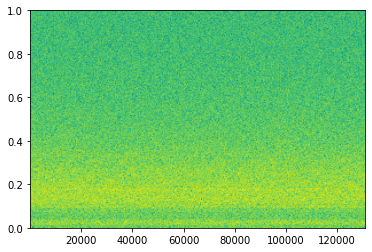

In [ ]:
from audio_diffusion_pytorch.diffusion import KarrasSampler, AEulerSampler, ADPM2Sampler, Diffusion, KarrasSchedule, Sampler, Schedule
num_steps=100
with torch.no_grad():
     samples = model_1.model.sample(
         noise=torch.randn((num_samples, 1, length_samples), device=DEVICE),
         num_steps=num_steps,
         sigma_schedule=KarrasSchedule(sigma_min=1e-4, sigma_max=1.0, rho=9.0),
         sampler=AEulerSampler(),
     )

# Log audio samples
for i, sample in enumerate(samples):
    import matplotlib.pyplot as plt
    display(Audio(sample.cpu(), rate = sampling_rate))
    spec, _, _, img = plt.specgram(sample.cpu().reshape(-1), NFFT=1024,)


In [ ]:
import matplotlib.pyplot as plt

def normal_pdf(x, mean:float=0.0, std: float = 1.0):
    return torch.exp(-0.5*((x - mean)/std**2)**2)/(std * (2*torch.pi)**0.5)

def lognormal_pdf(x:torch.Tensor, mean:float=0.0, std: float=1.0):
     return torch.exp(-0.5*((torch.log(x) - mean)/std**2)**2)/(x * std * (2*torch.pi)**0.5)
        
        
x = torch.arange(1e-4, 3, 0.001)
normal_y = normal_pdf(x, 0 ,1)
lognormal_y = lognormal_pdf(x, -3, 1)

#plt.plot(x, torch.cumsum(lognormal_y,0))
#lognormal_y
plt.plot(torch.sort(diffusion_sigma_distribution(10000))[0][::10])

plt.plot(KarrasSchedule(sigma_min=1e-4, sigma_max=3.0, rho=9.0)(1000,"cpu"))

In [ ]:
k = KarrasSchedule(sigma_min=1e-4, sigma_max=3.0, rho=9.0)
sigmas_rev = k(num_steps=99, device="cpu")

def compute_likelihood_steps(sigmas_rev: torch.tensor) -> torch.tensor:
    sigmas = sigmas_rev.flip(dims=[0])
    likelihood_steps = 1.0 / (torch.tensor([((2*(sigmas[:step])**2).sum()) for step in range(len(sigmas))]) + 5.0)
    return likelihood_steps.flip(dims=[0])

#step_size = torch.tensor([3e-1]*100)

import matplotlib.pyplot as plt
#plt.plot(sigmas)
plt.plot(compute_likelihood_steps(sigmas_rev))
plt.plot(step_size)

In [ ]:
import numpy as np
x_next = np.arange(1,100)/100
x = np.arange(2,101)/100
x_up = np.sqrt(x_next ** 2 * (x ** 2 - x_next ** 2) / x ** 2)
x_down = np.sqrt(x_next ** 2 - x_up ** 2)

#plt.plot(x_up)
plt.plot(x_down - x)
#plt.plot(x_down)

In [ ]:
n_fft=512
hop_length=64
speed_rate=1.5

spec = torchaudio.transforms.Spectrogram(hop_length=hop_length,n_fft=n_fft, power=None)
invspec = torchaudio.transforms.InverseSpectrogram(hop_length=hop_length,n_fft=n_fft)
ts1 = torchaudio.transforms.TimeStretch(hop_length, n_freq=n_fft//2+1, fixed_rate=speed_rate)
ts2 = torchaudio.transforms.TimeStretch(hop_length, n_freq=n_fft//2+1, fixed_rate=1/speed_rate)
#ps1 = torchaudio.transforms.PitchShift(hop_length, n_freq=n_fft//2+1, fixed_rate=1/speed_rate)

print(spec(s1).shape)
s1_rec = invspec(ts2(ts1(spec(s1))))
s1_rec = s1_rec[:,:,:length_samples]
print(si_snr(s1_rec,s1))
plot_waves(s1_rec,s1)
#plt.plot((s1_rec-s1).reshape(-1))

plt.plot(s1_rec.view(-1)[11000:11100:1])
plt.plot(s1.view(-1)[11000:11100:1])

print((s1_rec - s1).abs().max())

In [ ]:
torch.rand()

In [ ]:
length_samples